In [1]:
import numpy as np
from hypothesis.strategies import floats

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8

In [2]:
# %load /Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py
"""
A set of functions for data fitting.

GML November 2016
"""

import numpy as np
import scipy.optimize
import scipy.stats

from invisible_cities.core import core_functions as coref
from invisible_cities.evm.ic_containers    import FitFunction

def get_errors(cov):
    """
    Find errors from covariance matrix

    Parameters
    ----------
    cov : np.ndarray
        Covariance matrix of the fit parameters.

    Returns
    -------
    err : 1-dim np.ndarray
        Errors asociated to the fit parameters.
    """
    return np.sqrt(np.diag(cov))

def get_chi2_and_pvalue(ydata, yfit,  ndf, sigma=None):
    """
    Gets reduced chi2 and p-value

    Parameters
    ----------
    ydata : np.ndarray
        Data array
    ydata : np.ndarray
        Fit funtion values corresponding to ydata array
    sigma : np.ndarray
        Data errors array. If no sigma is given, it takes the poisson case.
    ndf : int
        Number of degrees of freedom
        (number of data points - number of parameters)

    Returns
    -------
    chi2 : float
        reduced chi2 (chi2 overnumber of degrees of freedom) computed value
        chi2 = [sum (ydata-yfit)**2 / sigma]
    pvalue : float
        p-value computed value
    """

    if sigma is None:
        sigma = ydata**0.5

    chi2   = np.sum(((ydata-yfit)/sigma)**2)
    pvalue = scipy.stats.chi2.sf(chi2, ndf)

    return chi2/ndf, pvalue

# ###########################################################
# Functions
def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)


def polynom(x, *coeffs):
    return np.polynomial.polynomial.polyval(x, coeffs)


def expo(x, const, mean):
    return const * np.exp(x/mean)


def power(x, const, pow_):
    return const * np.power(x, pow_)


# ###########################################################
# Tools
def fit(func, x, y, seed=(), fit_range=None, **kwargs):
    """
    Fit x, y data to a generic relation of already defined
    python functions.

    Parameters
    ----------
    func : function
        A callable object with signature (x, par0, par1, ...) where x is
        the value (or array of values) at which the function is evaluated
        and par represent the coefficients of the function.
    x, y : iterables
        Data sets to be fitted.
    seed : sequence
        Initial estimation of the fit parameters. Either all or none of them
        must be given.
    fit_range : tuple
        Range of x in which the fit is performed.
    Notes
    -----
    - Functions must be vectorized.

    Returns
    -------
    fitted_fun : extended function (contains values and errors)
        Fitted function.

    Examples
    --------
    >>> import numpy as np
    >>> import invisible_cities.core.fit_functions as fit
    >>> x = np.linspace(-5, 5, 100)
    >>> y = np.exp(-(x-1.)**2)
    >>> f = fit.fit(fit.gauss, x, y, (1., 2., 3))
    >>> print(f.values)
    [ 1.77245385  1.          0.70710678]
    """
    if fit_range is not None:
        sel  = coref.in_range(x, *fit_range)
        x, y = x[sel], y[sel]
        if "sigma" in kwargs:
            kwargs["sigma"] = kwargs["sigma"][sel]

    abs_sigma=True if "sigma" in kwargs else False

    vals, cov = scipy.optimize.curve_fit(func,
                                         x, y,
                                         seed,
                                         absolute_sigma=abs_sigma,
                                         **kwargs)

    fitf = lambda x: func(x, *vals)
    fitx = fitf(x)
    nonzero = fitx != 0

    sigma_r = kwargs.get("sigma", np.ones_like(y))
    sigma_r = sigma_r[nonzero]

    chi2, pval = get_chi2_and_pvalue(y[nonzero],
                                     fitx[nonzero],
                                     len(y[nonzero])-len(vals),
                                     sigma_r)

    return FitFunction(fitf,
                       vals,
                       get_errors(cov),
                       chi2,
                       pval)


def profileX(xdata, ydata, nbins=100,
             xrange=None, yrange=None,
             std=False, drop_nan=True):
    """
    Compute the x-axis binned average of a dataset.

    Parameters
    ----------
    xdata, ydata : 1-dim np.ndarray
        x and y coordinates from a dataset.
    nbins : int, optional
        Number of divisions in the x axis. Defaults to 100.
    xrange : tuple of ints/floats or None, optional
        Range over the x axis. Defaults to dataset extremes.
    yrange : tuple of ints/floats or None, optional
        Range over the y axis. Defaults to dataset extremes.
    drop_nan : bool, optional
        Exclude empty bins. Defaults to True.

    Returns
    -------
    x_out : 1-dim np.ndarray.
        Bin centers.
    y_out : 1-dim np.ndarray
        Data average for each bin.
    y_err : 1-dim np.ndarray
        Average error for each bin.
    """
    xmin, xmax = xrange if xrange else (np.min(xdata), np.max(xdata))
    ymin, ymax = yrange if yrange else (np.min(ydata), np.max(ydata))

    x_out = np.linspace(xmin, xmax, nbins+1)
    y_out = np.empty(nbins)
    y_err = np.empty(nbins)
    dx    = x_out[1] - x_out[0]

    selection = (coref.in_range(xdata, xmin, xmax) &
                 coref.in_range(ydata, ymin, ymax))
    x, y = xdata[selection], ydata[selection]
    for i in range(nbins):
        bin_data = y[coref.in_range(x,
                                    minval = x_out[i],
                                    maxval = x_out[i+1])]
        y_out[i] = coref.mean_handle_empty(bin_data)
        y_err[i] = coref. std_handle_empty(bin_data)
        if not std:
            y_err[i] /= bin_data.size ** 0.5

    x_out += dx / 2.
    x_out  = x_out[:-1]
    if drop_nan:
        selection = ~(np.isnan(y_out) | np.isnan(y_err))
        x_out = x_out[selection]
        y_out = y_out[selection]
        y_err = y_err[selection]
    return x_out, y_out, y_err


def profileY(xdata, ydata, nbins = 100,
             yrange=None, xrange=None,
             std=False, drop_nan=True):
    """
    Compute the y-axis binned average of a dataset.

    Parameters
    ----------
    xdata, ydata : 1-dim np.ndarray
        x and y coordinates from a dataset.
    nbins : int
        Number of divisions in the y axis.
    yrange : tuple of ints/floats or None, optional
        Range over the y axis. Defaults to dataset extremes.
    xrange : tuple of ints/floats or None, optional
        Range over the x axis. Defaults to dataset extremes.
    drop_nan : bool, optional
        Exclude empty bins. Defaults to True.

    Returns
    -------
    x_out : 1-dim np.ndarray.
        Bin centers.
    y_out : 1-dim np.ndarray
        Data average for each bin.
    y_err : 1-dim np.ndarray
        Average error for each bin.
    """
    return profileX(ydata, xdata, nbins, yrange, xrange, std, drop_nan)


def profileXY(xdata, ydata, zdata, nbinsx, nbinsy,
              xrange=None, yrange=None, zrange=None,
              std=False, drop_nan=True):
    """
    Compute the xy-axis binned average of a dataset.

    Parameters
    ----------
    xdata, ydata, zdata : 1-dim np.ndarray
        x, y, z coordinates from a dataset.
    nbinsx, nbinsy : int
        Number of divisions in each axis.
    xrange : tuple of ints/floats or None, optional
        Range over the x axis. Defaults to dataset extremes.
    yrange : tuple of ints/floats or None, optional
        Range over the y axis. Defaults to dataset extremes.
    zrange : tuple of ints/floats or None, optional
        Range over the z axis. Defaults to dataset extremes.
    drop_nan : bool, optional
        Exclude empty bins. Defaults to True.

    Returns
    -------
    x_out : 1-dim np.ndarray.
        Bin centers in the x axis.
    y_out : 1-dim np.ndarray.
        Bin centers in the y axis.
    z_out : 1-dim np.ndarray
        Data average for each bin.
    z_err : 1-dim np.ndarray
        Average error for each bin.
    """
    xmin, xmax = xrange if xrange else (np.min(xdata), np.max(xdata))
    ymin, ymax = yrange if yrange else (np.min(ydata), np.max(ydata))
    zmin, zmax = zrange if zrange else (np.min(zdata), np.max(zdata))

    x_out = np.linspace(xmin, xmax, nbinsx+1)
    y_out = np.linspace(ymin, ymax, nbinsy+1)
    z_out = np.empty((nbinsx, nbinsy))
    z_err = np.empty((nbinsx, nbinsy))
    dx = x_out[1] - x_out[0]
    dy = y_out[1] - y_out[0]

    selection = (coref.in_range(xdata, xmin, xmax) &
                 coref.in_range(ydata, ymin, ymax) &
                 coref.in_range(zdata, zmin, zmax))
    xdata, ydata, zdata = xdata[selection], ydata[selection], zdata[selection]
    for i in range(nbinsx):
        for j in range(nbinsy):
            selection = (coref.in_range(xdata, x_out[i], x_out[i+1]) &
                         coref.in_range(ydata, y_out[j], y_out[j+1]))
            bin_data = zdata[selection]
            z_out[i,j] = coref.mean_handle_empty(bin_data)
            z_err[i,j] = coref. std_handle_empty(bin_data)
            if not std:
                z_err[i,j] /= bin_data.size ** 0.5
    x_out += dx / 2.
    y_out += dy / 2.
    x_out  = x_out[:-1]
    y_out  = y_out[:-1]
    if drop_nan:
        selection = (np.isnan(z_out) | np.isnan(z_err))
        z_out[selection] = 0
        z_err[selection] = 0
    return x_out, y_out, z_out, z_err


In [26]:
# %load /Users/Gonzalo/github/IC/invisible_cities/core/fit_functions_test.py
"""
Tests for fit_functions
"""

import numpy as np
from pytest import mark
from flaky  import flaky

from numpy.testing import assert_array_equal
from numpy.testing import assert_allclose

from hypothesis            import given
from hypothesis.strategies import integers
from hypothesis.strategies import floats

from invisible_cities.core.testing_utils import float_arrays
from invisible_cities.core.testing_utils import FLOAT_ARRAY
from invisible_cities.core.testing_utils import random_length_float_arrays

from invisible_cities.core import core_functions as core
from invisible_cities.core import  fit_functions as fitf

from invisible_cities.icaro.hst_functions import poisson_sigma


def test_get_errors():
    data = np.array([[ 9, -2,  1],
                     [-1,  4, -1],
                     [ 2, -4,  1]], dtype=float)
    assert_array_equal(fitf.get_errors(data), [3., 2., 1.])


def test_chi2_1_and_pvalue():
    Nevt  = int(1e6)
    ydata = np.random.uniform(1, 100, Nevt)
    yfit  = np.zeros_like(ydata)
    errs  = ydata
    chi2, pvalue = fitf.get_chi2_and_pvalue(ydata, yfit, Nevt, errs)

    assert_allclose(chi2  , 1.0, rtol=1e-3)
    assert_allclose(pvalue, 0.5, rtol=1e-3)


@given(floats(min_value = -2500,
              max_value = +2500),
       floats(min_value = + 100,
              max_value = + 300))
def test_chi2_gauss(mean, sigma):
    Nevt  = int(1e6)

    ydata = np.random.normal(mean, sigma, Nevt)

    chi2, pvalue = fitf.get_chi2_and_pvalue(ydata, mean, Nevt-1, sigma)

    assert_allclose(chi2  , 1.0, rtol=1e-2)


def test_chi2_str_line():
    def line(x, m, n):
        return m*x + n

    y  = np.array([ 9.108e3, 10.34e3,   1.52387e5,   1.6202e5])
    ey = np.array([ 3.17   , 13.5   ,  70        ,  21       ])
    x  = np.array([29.7    , 33.8   , 481        , 511       ])

    f = fitf.fit(line, x, y, seed=(1,1), sigma=ey)

    assert_allclose(f.chi2, 14, rtol=1e-02)


@mark.slow
@flaky(max_runs=10, min_passes=9)
def test_chi2_poisson_errors():
    mu    = np.random.uniform(-100, 100)
    sigma = np.random.uniform(   0, 100)
    A     = 1e8 * np.sqrt(2 * np.pi) * sigma # to ensure high stats in faraway bins

    x     = np.linspace(mu - 5 * sigma,
                        mu + 5 * sigma,
                        100)
    y     = fitf.gauss(x, A, mu, sigma)
    y     = np.random.poisson(y)
    errs  = poisson_sigma(y)

    f     = fitf.fit(fitf.gauss, x, y, seed=(A, mu, sigma), sigma=errs)
    assert 0.60 < f.chi2 < 1.5


@mark.slow
@flaky(max_runs=10, min_passes=9)
def test_chi2_log_errors():
    mu    = np.random.uniform(-100, 100)
    sigma = np.random.uniform(   0, 100)
    A     = 1e8 * np.sqrt(2 * np.pi) * sigma # to ensure high stats in faraway bins

    x     = np.linspace(mu - 3 * sigma,
                        mu + 3 * sigma,
                        100)
    y     = fitf.gauss(x, A, mu, sigma)
    y     = np.random.normal(y, np.log(y))
    errs  = np.log(y)

    f = fitf.fit(fitf.gauss, x, y, seed=(A, mu, sigma), sigma=errs)

    assert 0.60 < f.chi2 < 1.5


@given(float_arrays(min_value=-10,
                    max_value=10))
def test_gauss_symmetry(data):
    assert_allclose(fitf.gauss( data, 1., 0., 1.),
                    fitf.gauss(-data, 1., 0., 1.))


#def test_gauss_breaks_when_sigma_is_negative():
#    assert_raises(ValueError,
#                  fitf.get_from_name,
#                  funname)


@given(integers(min_value = -100,
                max_value = +100),
       integers(min_value = -100,
                max_value = +100),
       integers(min_value = -100,
                max_value = +100),
       integers(min_value = -1  ,
                max_value = +100))
def test_gauss_works_with_integers(x, a, b, c):
    args = [x, a , b, c]
    assert_allclose(fitf.gauss(*args),
                    fitf.gauss(*map(float, args)))


@given(random_length_float_arrays(min_length = 1,
                                  max_length = 10,))
def test_polynom_at_zero(pars):
    assert_allclose(fitf.polynom(0., *pars),
                    pars[0])


@given(random_length_float_arrays(min_length = 1,
                                  max_length = 10,
                                  min_value  = 1e-8))
def test_polynom_at_one(pars):
    assert_allclose(fitf.polynom(1., *pars),
                    np.sum(pars), rtol=1e-5)


@given(floats(min_value = -20.,
              max_value = -10.),
       floats(min_value = -20.,
              max_value = -10.))
def test_expo_double_negative_sign(x, mean):
    assert fitf.expo(x, 1., mean) > fitf.expo(x+1., 1., mean)


@given(floats(min_value = +10.,
              max_value = +20.),
       floats(min_value = +10.,
              max_value = +20.))
def test_expo_double_positive_sign(x, mean):
    assert fitf.expo(x, 1., mean) < fitf.expo(x+1., 1., mean)


@given(floats(min_value = -20.,
              max_value = -10.),
       floats(min_value = +10.,
              max_value = +20.))
def test_expo_flipped_signs(x, b):
    assert fitf.expo(x, 1., b) < fitf.expo(x+1., 1., b)


@given(integers(min_value = -10,
                max_value = +10),
       integers(min_value = -10,
                max_value = +10),
       integers(min_value = -10,
                max_value = +10).filter(lambda x: x != 0))
def test_expo_works_with_integers(x, a, b):
    args = [x, a, b]
    assert_allclose(fitf.expo(*args),
                    fitf.expo(*map(float, args)))


@given(floats(min_value = -10.,
              max_value = +10.),
       floats(min_value = -10.,
              max_value = +10.))
def test_power_at_one(a, b):
    assert_allclose(fitf.power(1., a, b),
                    a)


@given(floats(min_value = -10.,
              max_value = +10.),
       floats(min_value =   0.,
              max_value = +10.).filter(lambda x: x != 0.))
def test_power_at_zero(a, b):
    assert_allclose(fitf.power(0., a, b),
                    0.)


@mark.parametrize("        fn                 pars        ".split(),
                  ((fitf.gauss         , (3.0,  2.0, 0.50)),
                   (fitf.expo          , (6.0,  1.5)),
                   (fitf.polynom       , (8.0, -0.5, 0.01)),
                   (fitf.power         , (0.1,  0.8))))
def test_fit(fn, pars):
    pars = np.array(pars)
    x = np.arange(10.)
    y = fn(x, *pars)
    f = fitf.fit(fn, x, y, pars * 1.5)
    assert_allclose(f.values, pars)


def test_fit_reduced_range():
    pars = np.array([1, 20, 5])
    x = np.linspace(0, 50, 100)
    y = fitf.gauss(x, *pars)

    f1 = fitf.fit(fitf.gauss, x, y, pars * 1.5)
    f2 = fitf.fit(fitf.gauss, x, y, pars * 1.5, fit_range=(10, 30))
    assert_allclose(f1.values, f2.values)


@mark.parametrize("reduced".split(),
                  ((True ,),
                   (False,)))
def test_fit_with_errors(reduced):
    pars = np.array([1e3, 1e2, 1e1])
    x = np.linspace(100, 300, 100)
    y = fitf.gauss(x, *pars)
    e = 0.1 * y

    fit_range = (50, 150) if reduced else None
    f = fitf.fit(fitf.gauss, x, y, pars * 1.2, fit_range=fit_range, sigma=e, maxfev=10000)
    assert_allclose(f.values, pars)


@mark.parametrize(["func"],
                  ((fitf.profileX,),
                   (fitf.profileY,)))
def test_profile1D_uniform_distribution(func):
    N    = 100000
    Nbin = 100
    n    = N / Nbin
    rms  = 12**-0.5
    eps  = rms * n**0.5

    xdata = np.random.rand(N)
    ydata = np.random.rand(N)
    xp, yp, ye = func(xdata, ydata, Nbin)

    assert np.allclose(yp, 0.5, atol=3*rms)
    assert np.allclose(ye, rms/n**0.5, rtol=eps)


@mark.parametrize(["func"],
                  ((fitf.profileX,),
                   (fitf.profileY,)))
@flaky(max_runs=3, min_passes=1)
def test_profile1D_uniform_distribution_std(func):
    N    = 100000
    Nbin = 100
    rms  = 12**-0.5

    xdata = np.random.rand(N)
    ydata = np.random.rand(N)
    xp, yp, ye = func(xdata, ydata, Nbin, std=True)

    assert np.allclose(ye, rms, rtol=0.1)


@mark.parametrize("func xdata ydata".split(),
                  ((fitf.profileX, FLOAT_ARRAY(100), FLOAT_ARRAY(100)),
                   (fitf.profileY, FLOAT_ARRAY(100), FLOAT_ARRAY(100))))
def test_profile1D_custom_range(func, xdata, ydata):
    xrange     = (-100, 100)
    kw         = "yrange" if func.__name__.endswith("Y") else "xrange"
    d          = {kw: xrange}
    xp, yp, ye = func(xdata, ydata, **d)
    assert np.all(core.in_range(xp, *xrange))


@mark.parametrize("func xdata ydata xrange".split(),
                  ((fitf.profileX,
                    FLOAT_ARRAY(100, -100, 100),
                    FLOAT_ARRAY(100, -500,   0),
                    (-100, 100)),
                   (fitf.profileY,
                    FLOAT_ARRAY(100, -100, 100),
                    FLOAT_ARRAY(100, -500,   0),
                    (-500, 0))))
def test_profile1D_full_range_x(func, xdata, ydata, xrange):
    xp, yp, ye = func(xdata, ydata)
    assert np.all(core.in_range(xp, *xrange))

@mark.skip(reason="Hypothesis can't handle sequences longer than 2**10")
#@mark.parametrize("func xdata ydata".split(),
#                  ((fitf.profileX,
#                    FLOAT_ARRAY(10000, -100, 100),
#                    FLOAT_ARRAY(10000, -500,   0)),
#                   (fitf.profileY,
#                    FLOAT_ARRAY(10000, -100, 100),
#                    FLOAT_ARRAY(10000, -500,   0))))
def test_profile1D_one_bin_missing_x(func, xdata, ydata):
    xdata[core.in_range(xdata, -2, 0)] += 5
    xp, yp, ye = func(xdata, ydata)
    assert xp.size == 99


@mark.parametrize("func xdata ydata".split(),
                  ((fitf.profileX,
                    FLOAT_ARRAY(100, min_value=-1e10, max_value=+1e10),
                    FLOAT_ARRAY(100, min_value=-1e10, max_value=+1e10)),
                   (fitf.profileY,
                    FLOAT_ARRAY(100, min_value=-1e10, max_value=+1e10),
                    FLOAT_ARRAY(100, min_value=-1e10, max_value=+1e10))))
def test_number_of_bins_matches(func, xdata, ydata):
    N = 50
    xp, yp, ye = func(xdata, ydata, N, drop_nan=False)
    assert xp.size == yp.size == ye.size == N


@mark.parametrize("func xdata ydata".split(),
                  ((fitf.profileX,
                    FLOAT_ARRAY(100),
                    FLOAT_ARRAY(100)),
                   (fitf.profileY,
                    FLOAT_ARRAY(100),
                    FLOAT_ARRAY(100))))
def test_empty_dataset_yields_nans(func, xdata, ydata):
    N = 50
    empty = np.array([])
    xp, yp, ye = func(empty, empty, N,
                      (-100, 100),
                      (-100, 100),
                      drop_nan=False)
    assert np.all(np.isnan(yp))
    assert np.all(np.isnan(ye))


@mark.slow
def test_profileXY_full_range():
    N    = 10000
    Nbin = 100
    rms  = 12**-0.5
    eps  = 0.2*rms * (N/Nbin)**0.5

    xdata = np.random.rand(N)
    ydata = np.random.rand(N)
    zdata = np.random.rand(N)
    xp, yp, zp, ze = fitf.profileXY(xdata,
                                   ydata,
                                   zdata,
                                   Nbin,
                                   Nbin)

    assert np.all(abs(zp - 0.5) < 3.00*rms)
    assert np.all(abs(ze - rms*(Nbin**2/N)**0.5) < eps)


In [27]:
n = 0
m = int(1000)
for i in range(m):
    try:
        test_chi2_poisson_errors()
    except:
        n += 1
n, 100*n/m

(3, 0.3)

In [28]:
n = 0
m = int(1000)
for i in range(m):
    try:
        test_chi2_log_errors()
    except:
        n += 1
n, 100*n/m

(2, 0.2)

# -------------------------------------------------------------------------------------------

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import invisible_cities.core.core_functions as coref
import invisible_cities.core. fit_functions as  fitf

from invisible_cities.icaro.hst_functions import *

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def test_weighted_mean_and_var_frequentist(mu, sigma, ndata):
    data = np.random.normal(mu, sigma, size=ndata)
    values, freqs = np.unique(data, return_counts=True)
    return coref.weighted_mean_and_var(values, freqs, unbiased=True, frequentist=True)

In [53]:
N    = 10000
mus  = np.random.uniform( 100, 100, N)
sigs = np.random.uniform(   1, 1, N)
ndat = np.random.randint(   5,  20, N)

aves, vars = zip(*map(test_weighted_mean_and_var_frequentist, mus, sigs, ndat))

1507 +- 11
0.0082 +- 0.0087
1.0392 +- 0.0087


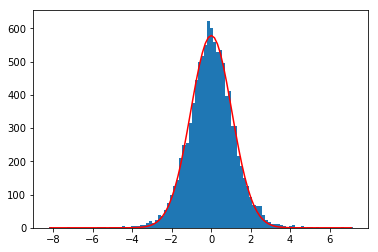

In [54]:
y, x, _ = hist((aves - mus)*(ndat/vars)**0.5, 100)
f = fitf.fit(fitf.gauss, x, y, (1,1,1))
plt.plot(x, f.fn(x), "r-")

for i in map(measurement_string, f.values, f.errors):
    print(i)

486.9 +- 7.4
0.8950 +- 0.0071
0.4085 +- 0.0073


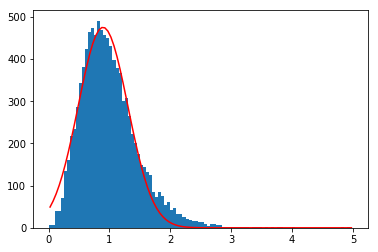

In [56]:
y, x, _ = hist(vars/sigs, 100, (0, 5))
f = fitf.fit(fitf.gauss, x, y, (1,1,1))
plt.plot(x, f.fn(x), "r-")

for i in map(measurement_string, f.values, f.errors):
    print(i)

In [28]:
import scipy as sc
import scipy.stats as st

In [40]:
a = st.f.cdf(vars/sigs, ndat - 1, int(1e15))
a[a > 1.000001]

array([], dtype=float64)

In [42]:
st.levene(data)

LeveneResult(statistic=8250.1826638588136, pvalue=0.0)

In [52]:
data_test = np.random.normal(1, 1, size=12)
data_true = np.random.normal(1, 1, size=120000)
st.levene(data_test, data_true)

LeveneResult(statistic=1.0120232151052413, pvalue=0.31442065507007821)

In [66]:
def test_weighted_mean_and_var_unbiased_reliability_weights(ndata):
    mu, sigma = 100, 1
    values = np.random.uniform(mu - 5 * sigma,
                               mu + 5 * sigma,
                               ndata)
    weights = fitf.gauss(values, 1, mu, sigma)

    ave, var = coref.weighted_mean_and_var(values, weights, unbiased=True, frequentist=False)
    return ave, var

In [75]:
ndat = np.random.randint(5, 20, size=10000)
a = np.array(list(map(test_weighted_mean_and_var_unbiased_reliability_weights, ndat)))

In [76]:
a

array([[ 100.02509615,    0.71166785],
       [  99.90641101,    1.13506431],
       [ 100.06349699,    1.47830934],
       ..., 
       [  99.61312965,    1.89441682],
       [  99.82456687,    1.80813394],
       [  99.56260885,    0.64248382]])

1481 +- 17
0.009 +- 0.014
1.050 +- 0.014


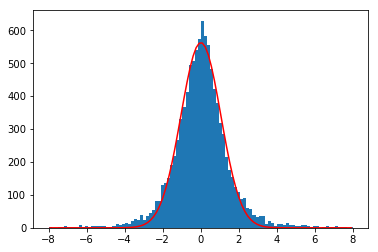

In [79]:
y, x, _ = hist((mu - 100)*(ndat/var)**0.5, 100, (-8, 8))
f = fitf.fit(fitf.gauss, x, y, (1,1,1))
plt.plot(x, f.fn(x), "r-")

for i in map(measurement_string, f.values, f.errors):
    print(i)